# Conference scheduling problem

In [1297]:
# !pip install mip

In [2]:
import pandas as pd
import numpy as np

## Problem Statement

Recently Slalom Seattle was planning it's annual Innovation Symposium, and I was on the planning committee.

The planning team wanted to assign each individual to a schedule. Attendees had been asked to rank their preference for attending each topic. The problem was a large number of schedules would have to manually be created; over 600 attendees, needed to be assigned to 7 different topics across 3 sessions. The original plan was to whiteboard it and manually create schedules and assign people to schedules, an excruciating process that may have to be rerun as new responses or constraints came in. It also seemed difficult to ensure the best solution: how do you even pick the best subset of possible schedules?

There were also some constraints about the capacity of available rooms, more popular sessions could be put in a larger room, and we wanted to avoid having rooms half empty in one session and then bursting at the seams in a later session.

### 2022 Bonus Complexity
In 2022 a number of the attendees will be virtual while

**Problem:** Creates quadratic complexity when adding in in person / virtual constraint. Maybe there's a better way to solve this?  
Have tried converting bool quadratic into 4 constraints (for each multiplication!!!!).  
https://orinanobworld.blogspot.com/2010/10/binary-variables-and-quadratic-terms.html  
https://python-mip.readthedocs.io/en/latest/examples.html  
https://docs.python-mip.com/en/latest/examples.html  
https://math.stackexchange.com/questions/2776824/adding-a-combination-of-and-or-operator-constraint-in-linear-programming/2778110#2778110=  
https://en.wikipedia.org/wiki/Big_M_method  
logic table: https://www.wolframalpha.com/input?i=X+%26%26+%28A+%5E+S%29

## Data Prep

### Let's have a look at the survey data

In [3]:
# Read data
file='data/selections_2022.csv'
df = pd.read_csv(file)
df.head(5)

,Do you plan on attending the Shape the Future Symposium?,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5,Choice 6,Choice 7,Choice 8,Choice 9,Choice 10,Choice 11,Choice 12,Choice 13
0,"Yes, I will attend in person",Architecting for a Sustainable Cloud Future,The Future of Work: What You Need to Know to N...,Environmental Impact @ Slalom with Net Zero Cloud,Starbucks Experimentation Program,Shaping the Future Through Inspiration and Inn...,ESG 101,Introduction to the Seattle Sustainability Team,Energy Demand Nowcasting: How Machine Learning...,Modern Portfolio Management,Build a Bot Using PowerAutomate,Fusion Development with the Microsoft Power Pl...,Low Code – Meeting User Needs While Also Being...,MIDL Earth - Digitized
1,"Yes, I will attend virtually",Fusion Development with the Microsoft Power Pl...,Architecting for a Sustainable Cloud Future,Service Design: A Framework for Practical Coll...,Build a Bot Using PowerAutomate,Shaping the Future Through Inspiration and Inn...,Introduction to the Seattle Sustainability Team,ESG 101,Low Code – Meeting User Needs While Also Being...,Energy Demand Nowcasting: How Machine Learning...,The Future of Work: What You Need to Know to N...,Environmental Impact @ Slalom with Net Zero Cloud,MIDL Earth - Digitized,Starbucks Experimentation Program
2,"Yes, I will attend virtually",Build a Bot Using PowerAutomate,Architecting for a Sustainable Cloud Future,Low Code – Meeting User Needs While Also Being...,MIDL Earth - Digitized,Fusion Development with the Microsoft Power Pl...,Shaping the Future Through Inspiration and Inn...,Introduction to the Seattle Sustainability Team,ESG 101,Energy Demand Nowcasting: How Machine Learning...,The Future of Work: What You Need to Know to N...,Environmental Impact @ Slalom with Net Zero Cloud,Starbucks Experimentation Program,Modern Portfolio Management
3,"Yes, I will attend in person",Build a Bot Using PowerAutomate,Fusion Development with the Microsoft Power Pl...,Shaping the Future Through Inspiration and Inn...,Introduction to the Seattle Sustainability Team,ESG 101,Low Code – Meeting User Needs While Also Being...,Architecting for a Sustainable Cloud Future,Energy Demand Nowcasting: How Machine Learning...,The Future of Work: What You Need to Know to N...,Environmental Impact @ Slalom with Net Zero Cloud,MIDL Earth - Digitized,Starbucks Experimentation Program,Modern Portfolio Management
4,"Yes, I will attend in person",Starbucks Experimentation Program,The Future of Work: What You Need to Know to N...,Low Code – Meeting User Needs While Also Being...,Build a Bot Using PowerAutomate,Fusion Development with the Microsoft Power Pl...,Shaping the Future Through Inspiration and Inn...,Introduction to the Seattle Sustainability Team,ESG 101,Architecting for a Sustainable Cloud Future,Energy Demand Nowcasting: How Machine Learning...,Environmental Impact @ Slalom with Net Zero Cloud,MIDL Earth - Digitized,Modern Portfolio Management


In [4]:
# Drop non attendees
df = df[df['Do you plan on attending the Shape the Future Symposium?'] != 'No, I will not attend']

In [5]:
a_virt = df[['Do you plan on attending the Shape the Future Symposium?']].copy()
df.drop('Do you plan on attending the Shape the Future Symposium?', axis=1, inplace=True)
# df = df[df.columns[:7]]

In [6]:
index = a_virt.index

In [7]:
a_virt.value_counts()

Do you plan on attending the Shape the Future Symposium?
Yes, I will attend in person                                279
Yes, I will attend virtually                                148
dtype: int64

In [8]:
a_virt = (a_virt == 'Yes, I will attend virtually').values.ravel()

Each row represents an attendee, and the columns are their ranked preference for each topic. Choice 1 was their highest preference and Choice 7 was their lowest.

In [9]:
df.describe()

,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5,Choice 6,Choice 7,Choice 8,Choice 9,Choice 10,Choice 11,Choice 12,Choice 13
count,415,415,415,415,415,415,415,415,415,415,415,415,415
unique,15,15,15,15,15,15,15,15,14,14,15,15,15
top,Build a Bot Using PowerAutomate,The Future of Work: What You Need to Know to N...,Service Design: A Framework for Practical Coll...,Shaping the Future Through Inspiration and Inn...,Build a Bot Using PowerAutomate,Fusion Development with the Microsoft Power Pl...,Introduction to the Seattle Sustainability Team,ESG 101,Architecting for a Sustainable Cloud Future,Energy Demand Nowcasting: How Machine Learning...,Environmental Impact @ Slalom with Net Zero Cloud,MIDL Earth - Digitized,Modern Portfolio Management
freq,67,53,46,47,116,104,78,80,77,92,95,110,105


Looks like there are a number of missing values where someone either hasn't provided a ranking (but they've confirmed they're attending) or they have only provided a top 1,2,3... We'll have to handle all of these cases.

In [10]:
# Get total number of respondants
N_total = len(df)
print(f'Total number of responses: {N_total}')

# Create a dictionary of the topics for later use
topics = np.unique(df.dropna().values)
# topic_map = dict(zip(topics,range(len(topics))))

Total number of responses: 427


In [11]:
topics

array(['Architecting for a Sustainable Cloud Future',
       'Build a Bot Using PowerAutomate',
       'Customer Data Platforms:  The Innovative intersection of Martech, Machine Learning, and Customer Data',
       'ESG 101',
       'Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement',
       'Environmental Impact @ Slalom with Net Zero Cloud',
       'Fusion Development with the Microsoft Power Platform',
       'Introduction to the Seattle Sustainability Team',
       'Low Code – Meeting User Needs While Also Being Fast and Lean',
       'MIDL Earth - Digitized ', 'Modern Portfolio Management',
       'Service Design: A Framework for Practical Collaboration',
       'Shaping the Future Through Inspiration and Innovation',
       'Starbucks Experimentation Program',
       'The Future of Work: What You Need to Know to Navigate this Brave New World'],
      dtype=object)

### Convert the data into a convenient format

The data format isn't ideal; we'd like to have topics as the columns and rankings as integer values in the table.

Let's convert this into a more convenient shape.

In [12]:
# Convert to ranked format
df = df.reset_index().melt(id_vars='index').dropna().pivot(columns='value',index='index', values='variable') # Index = the id of a particular response
df = df.reindex(index) # Reindex because the previous step dropped all the rows where respondant didn't provide any preferences at all

In [13]:
# Remove session MIDL Earth
df.drop('MIDL Earth - Digitized ',axis=1,inplace=True)
topics = np.delete(topics, np.where(topics == 'MIDL Earth - Digitized '))

# Remove session CDP
df.drop('Customer Data Platforms:  The Innovative intersection of Martech, Machine Learning, and Customer Data',axis=1,inplace=True)
topics = np.delete(topics, np.where(topics == 'Customer Data Platforms:  The Innovative intersection of Martech, Machine Learning, and Customer Data'))

In [14]:
# Convert choice rankings to integers
def choice_to_int(choice):
    try:
        return int(choice.split(' ')[-1])
    except:
        return np.nan

choice_to_int('Choice 2'), choice_to_int(np.nan)

(2, nan)

In [15]:
# Use applymap to clean every choice
df = df.applymap(choice_to_int)

In [16]:
# Merge sessions Modern Portfolio Management / Starbucks Experimentation Program = Modern Portfolio Management
df['Modern Portfolio Management'] = df.apply(lambda x: min(x['Modern Portfolio Management'], x['Starbucks Experimentation Program']), axis=1)
df.drop('Starbucks Experimentation Program',axis=1, inplace=True)
topics = np.delete(topics, np.where(topics == 'Starbucks Experimentation Program'))

In [17]:
# Merge sessions Modern Portfolio Management / Starbucks Experimentation Program = Modern Portfolio Management
df['ESG 101'] = df.apply(lambda x: min(x['ESG 101'], x['Introduction to the Seattle Sustainability Team']), axis=1)
df.drop('Introduction to the Seattle Sustainability Team',axis=1, inplace=True)
topics = np.delete(topics, np.where(topics == 'Introduction to the Seattle Sustainability Team'))

We also want to fill missing preferences; we'll assume an individual's preference for topics not ranked is uniform but lower than those they have ranked.

In [18]:
# Add one to the max choice for each row
unranked_preference = df.max(axis=1).fillna(0) +1

# The column by column replace the missing values with the max per row
for col in df.columns:
    df[col] = df[col].fillna(value=unranked_preference)
df.sample(5, random_state=1990)

value,Architecting for a Sustainable Cloud Future,Build a Bot Using PowerAutomate,ESG 101,Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement,Environmental Impact @ Slalom with Net Zero Cloud,Fusion Development with the Microsoft Power Platform,Low Code – Meeting User Needs While Also Being Fast and Lean,Modern Portfolio Management,Service Design: A Framework for Practical Collaboration,Shaping the Future Through Inspiration and Innovation,The Future of Work: What You Need to Know to Navigate this Brave New World
242,10.0,1.0,9.0,2.0,11.0,7.0,4.0,3.0,12.0,8.0,5.0
305,8.0,1.0,2.0,6.0,9.0,4.0,13.0,11.0,14.0,7.0,3.0
101,2.0,6.0,9.0,12.0,13.0,7.0,11.0,4.0,1.0,8.0,3.0
296,10.0,6.0,3.0,12.0,14.0,7.0,8.0,1.0,2.0,9.0,13.0
286,9.0,1.0,6.0,4.0,11.0,5.0,8.0,2.0,12.0,3.0,10.0


You can see the response at index `410` didn't provide any choice so every topic has a rank 1.

In [19]:
# Replace all with rank of value
df = df.apply(lambda x: x.rank(method='min'),axis=1)

## Analyze Top 3 choices

In [20]:
top3 = pd.DataFrame(data=df.values, columns=df.columns.values)
top3['virtual'] = a_virt
top3 = top3.reset_index().melt(id_vars=['index','virtual'])
top3 = top3[top3.value<=3]
top3.value = 1
top3.pivot_table(values='value',index='variable',columns='virtual',aggfunc='sum')

virtual,False,True
variable,,
Architecting for a Sustainable Cloud Future,68,43
Build a Bot Using PowerAutomate,106,43
ESG 101,63,36
Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement,48,23
Environmental Impact @ Slalom with Net Zero Cloud,45,20
Fusion Development with the Microsoft Power Platform,47,31
Low Code – Meeting User Needs While Also Being Fast and Lean,95,51
Modern Portfolio Management,133,58
Service Design: A Framework for Practical Collaboration,91,45


## Solve Using Linear Programming

We can restate this as a linear programming problem where we have various constraints on the number of attendees in each session, and the number of sessions and topics a particular person can attend. 

### Assign preference cost
We want to assign costs for assigning a particular person to a session, that way we can compute a total of cost of a configuration, and optimize. We can say the cost is zero for assigning them to one of their top 3 sessions, with an increasing cost if we assign them to a lower preference session.

Depending on the problem and constraints we might choose different values here. For example if we want to avoid assigning any non-top 3 choices at all we could use a higher value for Choice 4 and on.

In [21]:
cost_array = [0,0,0,4,10,11,12,13,14,15,16,17,18]
cost_remap = {i:cost_array[i-1] for i in range(1,len(cost_array)+1)}
print(f'Costs by choice: {cost_remap}')

# Remap values in dataframe
df = df.replace(cost_remap).astype(np.int8) # apply our map, and convert to int
df.sample(5, random_state=1990)

Costs by choice: {1: 0, 2: 0, 3: 0, 4: 4, 5: 10, 6: 11, 7: 12, 8: 13, 9: 14, 10: 15, 11: 16, 12: 17, 13: 18}


value,Architecting for a Sustainable Cloud Future,Build a Bot Using PowerAutomate,ESG 101,Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement,Environmental Impact @ Slalom with Net Zero Cloud,Fusion Development with the Microsoft Power Platform,Low Code – Meeting User Needs While Also Being Fast and Lean,Modern Portfolio Management,Service Design: A Framework for Practical Collaboration,Shaping the Future Through Inspiration and Innovation,The Future of Work: What You Need to Know to Navigate this Brave New World
242,14,0,13,0,15,11,4,0,16,12,10
305,12,0,0,10,13,4,15,14,16,11,0
101,0,10,13,15,16,11,14,4,0,12,0
296,13,4,0,14,16,10,11,0,0,12,15
286,13,0,11,4,15,10,12,0,16,0,14


### Convert to a 3D cost matrix
We need to assign a cost for allocating each attendee to a topic in each session. There are three sessions and the cost should be the same for a particular attendee to attend a topic regardless of the order they attend. So we need to transform our 2D array of costs into a 3D matrix.

We don't really need a 3D cost matrix but it makes it easier to index and the array in the same way when working through constraints.

In [26]:
cost_matrix = np.dot(np.expand_dims(df.values,-1), np.array([[1,1,1]]))
print(f'First dataframe row:\n{df.iloc[0]}', f'Corresponding item from cost array:\n{cost_matrix[0]}', f'Shape of full array: {cost_matrix.shape}', sep='\n\n')

First dataframe row:
value
Architecting for a Sustainable Cloud Future                                       0
Build a Bot Using PowerAutomate                                                  13
ESG 101                                                                          11
Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement    12
Environmental Impact @ Slalom with Net Zero Cloud                                 0
Fusion Development with the Microsoft Power Platform                             14
Low Code – Meeting User Needs While Also Being Fast and Lean                     15
Modern Portfolio Management                                                       4
Service Design: A Framework for Practical Collaboration                          16
Shaping the Future Through Inspiration and Innovation                            10
The Future of Work: What You Need to Know to Navigate this Brave New World        0
Name: 0, dtype: int8

Corresponding item from cos

### Mixed Integer Programming

Google provides a fast and open source library for solving various combinatorial optimization problems: [Google OR tools](https://developers.google.com/optimization/)([GitHub](https://github.com/google/or-tools)). There are a few ways we could solve this but we'll use the [Mixed Integer Programming (MIP) package](https://developers.google.com/optimization/assignment/assignment_mip).

First we need to provide a room capacity, we can adjust these numbers iteratively to best fit sessions into rooms. The iteration process went as follows: assign room capacities run solver, evaluate variance in attendance across sessions and adjust session capacities accordingly.

In [27]:
len(topics)

11

In [168]:
# Set max capacity per room
topic_capacities = [45]*len(topics)
# topic_capacities = [30]*len(topics)
# topic_capacities[0] = 20
# topic_capacities[1] = 35
# topic_capacities[7] = 42
# topic_capacities[9] = 35
# topic_capacities[10] = 32
list(zip(topics,topic_capacities))

[('Architecting for a Sustainable Cloud Future', 40),
 ('Build a Bot Using PowerAutomate', 40),
 ('ESG 101', 40),
 ('Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement',
  40),
 ('Environmental Impact @ Slalom with Net Zero Cloud', 40),
 ('Fusion Development with the Microsoft Power Platform', 40),
 ('Low Code – Meeting User Needs While Also Being Fast and Lean', 40),
 ('Modern Portfolio Management', 40),
 ('Service Design: A Framework for Practical Collaboration', 40),
 ('Shaping the Future Through Inspiration and Innovation', 40),
 ('The Future of Work: What You Need to Know to Navigate this Brave New World',
  40)]

In [169]:
N_topics = len(topics)
N_sessions = 3

### Create a model and define contraints

In [170]:
a_virt = [bool(x) for x in a_virt]

In [171]:
a_in_p = [not bool(x) for x in a_virt]

Here's how I figured out the logic in Excel
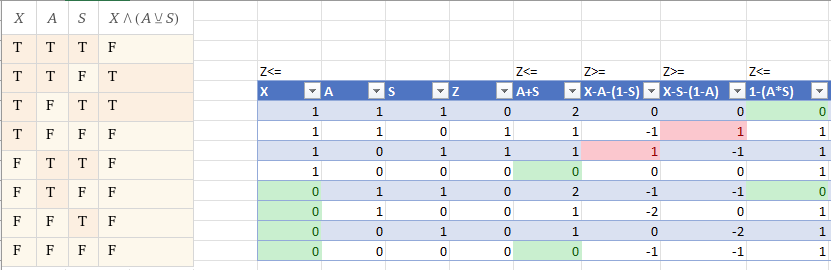

In [172]:
## Create solver model
from mip import Model, xsum, BINARY, minimize, OptimizationStatus, INTEGER

model = Model()

## Create assignment array
# A boolean (True/False) value for each possible attendee, topic, session combination
# We'll store these in a Numpy array of object datatype for easy indexing
# By summing across dimesions of the array we can view and enforce constraints
# In Python True is evaluated as 1 in a summation and False is evaluated as 0
x = np.zeros((N_total,N_topics,N_sessions), dtype=object)
for attendee in range(N_total):
    for topic in range(N_topics):
        for session in range(N_sessions):
            x[attendee, topic, session] = model.add_var(f'x[{attendee}, {topic}, {session}]',
                                                        var_type=BINARY)

# Variable for virtual sessions            
s_virt = np.zeros((N_topics,N_sessions), dtype=object)
for t in range(N_topics):
    for s in range (N_sessions):
        s_virt[t,s] = model.add_var(f's_v[{t},{s}]', var_type=BINARY)

# Allow multiplication of variables as per https://groups.google.com/g/python-mip/c/rhS_a78_qx8
z = np.zeros((N_total,N_topics,N_sessions), dtype=object)
for a in range(N_total):
    for t in range(N_topics):
        for s in range (N_sessions):
            # Create variable
            z[a,t,s] = model.add_var(f'z[{a},{t},{s}]', var_type=BINARY)
            # Combination of linear terms that equate to required boolean logic
            
            # Turns out we don't need the values forcing z to be zero if we make this a hard constraint no people can both be virtual and attend in person and vice versa
            # Removing these constarins and objectives makes the solver run much faster and finds better solutions
            # model.add_constr( z[a,t,s] <= x[a,t,s] ) # Enforces z=0 when x=0 - no penalty (Z<=) when not present
            # model.add_constr( z[a,t,s] <= a_virt[a] + s_virt[t,s]) # Enforces not a and not s - both attendee and session are in person, no penalty (Z<=)
            # model.add_constr( z[a,t,s] <= 1 - (a_virt[a] * s_virt[t,s]) ) # Enforces a and s - both attendee and session are virtual, no penalty (Z<=)
            model.add_constr( z[a,t,s] >= x[a,t,s] - a_virt[a] - (1 - s_virt[t,s]) ) # Enforces penalty (Z>=) when attending and not virtual but session is 
            model.add_constr( z[a,t,s] >= x[a,t,s] - s_virt[t,s] - (1 - a_virt[a]) ) # Enforces penalty (Z>=) when virtually attending but session is in person
            
            # Make this a hard constraint i.e. this must be zero but x and s_virt must also conform to these constraints
            model.add_constr( z[a,t,s] == 0 )

## Objective - minimize the cost of attending non-top3 events
obj = []
for a in range(N_total):
    for t in range(N_topics):
        for s in range (N_sessions):
            # Creates the objective to minimize the cost for attending a non top3 pick
            obj.append(cost_matrix[a,t,s] * x[a,t,s])
            # Minimize the number of in person people attending virtual sessions and vice versa - NB made this a constraint by adding z==0 above
            # obj.append(99*z[a,t,s]) 

model.objective = minimize(xsum(obj))

## Add constraints to the model
# Each attendee attends exactly one topic per session
# Therefore the sum across topics for each attendee, session is 1
for a in range(N_total):
    for s in range(N_sessions):
        model += xsum(x[a,t,s] for t in range(N_topics)) == 1

# Each attendee attends each topic no more than 1 time
# For each attendee, topic the sum can be 1 or 0
for a in range(N_total):
    for t in range(N_topics):
        model += xsum(x[a,t,s] for s in range(N_sessions)) <= 1

# Max people per session
# Total count of attendees for each session to be less than capacities defined
for s in range(N_sessions):
    for t in range(N_topics):
        # #No virtual sessions for topics 3,4
        # if t in [3,4]:
        #     model += xsum(a_virt[a] * x[a,t,s] for a in range(N_total)) == 0
        model += xsum(a_in_p[a] * x[a,t,s] for a in range(N_total)) <= topic_capacities[t] # Only care about in person capacities
        # model += xsum(a_in_p[a] * x[a,t,s] for a in range(N_total)) >= 15

In [173]:
# optimizing
model.optimize(max_seconds=3*60)

<OptimizationStatus.FEASIBLE: 3>

In [174]:
model.objective.x

1728.0

In [175]:
s_sol = np.full_like(s_virt,0, dtype=int)
for t in range(N_topics):
    for s in range(N_sessions):
        s_sol[t,s] = s_virt[t,s].x

In [176]:
# Return resulting solution to a new array
x_sol = np.full_like(x, 0, dtype=int)
for a in range(N_total):
    for t in range(N_topics):
        for s in range(3):
            x_sol[a,t,s] = x[a,t,s].x

In [177]:
# Return resulting solution to a new array
z_sol = np.full_like(z, 0, dtype=int)
for a in range(N_total):
    for t in range(N_topics):
        for s in range(3):
            z_sol[a,t,s] = z[a,t,s].x

In [178]:
# People not in top 3
np.sum((x_sol * cost_matrix))

1728

In [179]:
np.sum(z_sol)

0

## Run Optimizer again with fixed virtual / non virtual

In [180]:
s_sol

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [181]:
## Create solver model
from mip import Model, xsum, BINARY, minimize, OptimizationStatus, INTEGER

model = Model()

## Create assignment array
# A boolean (True/False) value for each possible attendee, topic, session combination
# We'll store these in a Numpy array of object datatype for easy indexing
# By summing across dimesions of the array we can view and enforce constraints
# In Python True is evaluated as 1 in a summation and False is evaluated as 0
x = np.zeros((N_total,N_topics,N_sessions), dtype=object)
for attendee in range(N_total):
    for topic in range(N_topics):
        for session in range(N_sessions):
            x[attendee, topic, session] = model.add_var(f'x[{attendee}, {topic}, {session}]',
                                                        var_type=BINARY)

# Enforce: No virtual sessions have in person attendees and vice versa
# The reason we can multiply x and s now is that s is now a constant; otherwise we would have a quadratic problem 
model += xsum([s_sol[t,s] * (not a_virt[a]) * x[a,t,s] for a in range(N_total) for t in range(N_topics) for s in range(N_sessions)]) == 0
model += xsum([(not s_sol[t,s]) * a_virt[a] * x[a,t,s] for a in range(N_total) for t in range(N_topics) for s in range(N_sessions)]) == 0
        
obj = []
for a in range(N_total):
    for t in range(N_topics):
        for s in range (N_sessions):
            obj.append(cost_matrix[a,t,s] * x[a,t,s])

model.objective = minimize(xsum(obj))

## Add constraints to the model
# Each attendee attends exactly one topic per session
# Therefore the sum across topics for each attendee, session is 1
for a in range(N_total):
    for s in range(N_sessions):
        model += xsum(x[a,t,s] for t in range(N_topics)) == 1

# Each attendee attends each topic no more than 1 time
# For each attendee, topic the sum can be 1 or 0
for a in range(N_total):
    for t in range(N_topics):
        model += xsum(x[a,t,s] for s in range(N_sessions)) <= 1

# Max people per session
# Total count of attendees for each session to be less than capacities defined
for s in range(N_sessions):
    for t in range(N_topics):
        model += xsum(a_in_p[a] * x[a,t,s] for a in range(N_total)) <= topic_capacities[t]

In [182]:
# optimizing
model.optimize(max_seconds=30)

<OptimizationStatus.OPTIMAL: 0>

In [183]:
model.objective.x

1530.0

In [184]:
# Return resulting solution to a new array
x_sol = np.full_like(x, 0, dtype=int)
for a in range(N_total):
    for t in range(N_topics):
        for s in range(3):
            x_sol[a,t,s] = x[a,t,s].x

In [185]:
# People not in top 3
np.sum((x_sol * cost_matrix))

1530

In [186]:
not_top_3 = np.where(x_sol*cost_matrix>0)
for i,a in enumerate(not_top_3[0]):
    print(f'Attendee {a} for topic {not_top_3[1][i]}, session {not_top_3[2][i]}, had a cost of {cost_matrix[a,not_top_3[1][i],not_top_3[2][i]]}, attendee is virtual?: {a_virt[a]}', end='\n')

Attendee 1 for topic 1, session 1, had a cost of 4, attendee is virtual?: True
Attendee 2 for topic 5, session 2, had a cost of 4, attendee is virtual?: True
Attendee 3 for topic 2, session 0, had a cost of 4, attendee is virtual?: False
Attendee 7 for topic 5, session 2, had a cost of 4, attendee is virtual?: True
Attendee 9 for topic 0, session 0, had a cost of 11, attendee is virtual?: True
Attendee 10 for topic 5, session 2, had a cost of 11, attendee is virtual?: True
Attendee 10 for topic 9, session 0, had a cost of 4, attendee is virtual?: True
Attendee 16 for topic 2, session 2, had a cost of 4, attendee is virtual?: False
Attendee 17 for topic 4, session 2, had a cost of 4, attendee is virtual?: False
Attendee 20 for topic 4, session 2, had a cost of 4, attendee is virtual?: False
Attendee 23 for topic 6, session 1, had a cost of 4, attendee is virtual?: False
Attendee 24 for topic 8, session 1, had a cost of 4, attendee is virtual?: False
Attendee 26 for topic 0, session 2, h

In [187]:
# Number of people in person that are attending a virtual event
in_person_attending_virtual = np.array([a * s_sol for a in a_in_p]) * x_sol
np.sum(in_person_attending_virtual)

0

In [157]:
# ipav = np.where(in_person_attending_virtual > 0)
# for i,a in enumerate(ipav[0]):
#     print(f'Attendee {a} for topic {ipav[1][i]}, session {ipav[2][i]}, is virtual: {a_virt[a]}. Session is virtual: {s_sol[ipav[1][i],ipav[2][i]]==1}', end='\n')

In [158]:
# Number of virtual attending an in person event
virtual_attending_in_person = np.array([a * 1 * (s_sol == 0) for a in a_virt]) * x_sol
np.sum(virtual_attending_in_person)

0

In [134]:
# indexes_of_virtual_attending_ip = np.unique(np.where(virtual_attending_in_person > 0)[0])
# ivap = np.where(virtual_attending_in_person > 0)
# for i,a in enumerate(ivap[0]):
#     print(f'Attendee {a} for topic {ivap[1][i]}, session {ivap[2][i]}, is virtual: {a_virt[a]}. Session is virtual: {s_sol[ivap[1][i],ivap[2][i]]==1}', end='\n')

## Evaluating the Solution

### Did our solver find an optimal solution?

In [188]:
model.status == OptimizationStatus.OPTIMAL

True

In this case it did, great! If we tighten the constraints this might not always be true. For example reducing the room capacities.

What about the total cost:

In [189]:
model.objective.x

1530.0

Great this means everyone gets to attend their top 3 sessions.

### How many attendees in each session?
We want to check that there isn't significant varaince across sessions so that we avoid half empty rooms in some sessions.

In [190]:
print("Total numbers in each session")
pd.DataFrame(x_sol.sum(axis=0),index=topics,columns=['S1','S2','S3'], dtype=int)

Total numbers in each session


,S1,S2,S3
Architecting for a Sustainable Cloud Future,52,38,40
Build a Bot Using PowerAutomate,40,63,40
ESG 101,28,23,30
Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement,23,29,28
Environmental Impact @ Slalom with Net Zero Cloud,16,23,36
Fusion Development with the Microsoft Power Platform,22,29,57
Low Code – Meeting User Needs While Also Being Fast and Lean,30,40,34
Modern Portfolio Management,40,62,40
Service Design: A Framework for Practical Collaboration,40,40,19
Shaping the Future Through Inspiration and Innovation,96,40,40


In [191]:
print("In person attendees")
pd.DataFrame(np.array([a*x_sol[i] for i,a in enumerate(a_in_p)]).sum(axis=0),index=topics,columns=['S1','S2','S3'], dtype=int)

In person attendees


,S1,S2,S3
Architecting for a Sustainable Cloud Future,0,38,40
Build a Bot Using PowerAutomate,40,0,40
ESG 101,28,23,30
Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement,23,29,0
Environmental Impact @ Slalom with Net Zero Cloud,16,0,36
Fusion Development with the Microsoft Power Platform,22,29,0
Low Code – Meeting User Needs While Also Being Fast and Lean,30,40,34
Modern Portfolio Management,40,0,40
Service Design: A Framework for Practical Collaboration,40,40,19
Shaping the Future Through Inspiration and Innovation,0,40,40


In [192]:
print('Virtual Attendees')
pd.DataFrame(np.array([a*x_sol[i] for i,a in enumerate(a_virt)]).sum(axis=0),index=topics,columns=['S1','S2','S3'], dtype=int)

Virtual Attendees


,S1,S2,S3
Architecting for a Sustainable Cloud Future,52,0,0
Build a Bot Using PowerAutomate,0,63,0
ESG 101,0,0,0
Energy Demand Nowcasting: How Machine Learning can Help Unlock ESG Enablement,0,0,28
Environmental Impact @ Slalom with Net Zero Cloud,0,23,0
Fusion Development with the Microsoft Power Platform,0,0,57
Low Code – Meeting User Needs While Also Being Fast and Lean,0,0,0
Modern Portfolio Management,0,62,0
Service Design: A Framework for Practical Collaboration,0,0,0
Shaping the Future Through Inspiration and Innovation,96,0,0


## Save resulting conference schedules

In [193]:
len(a_virt), sum(a_virt), sum([not a for a in a_virt])

(427, 148, 279)

In [194]:
schedule = np.argmax(x_sol,axis=1)
schedule_text = topics[schedule]
sched_df = pd.DataFrame(schedule_text, columns=[f'Session {i}' for i in range(1,4)], index=index)
sched_df['Virtual Attendee'] = a_virt
sched_df.head()

,Session 1,Session 2,Session 3,Virtual Attendee
0,The Future of Work: What You Need to Know to N...,Architecting for a Sustainable Cloud Future,Environmental Impact @ Slalom with Net Zero Cloud,False
1,Architecting for a Sustainable Cloud Future,Build a Bot Using PowerAutomate,Fusion Development with the Microsoft Power Pl...,True
2,Architecting for a Sustainable Cloud Future,Build a Bot Using PowerAutomate,Fusion Development with the Microsoft Power Pl...,True
3,ESG 101,Fusion Development with the Microsoft Power Pl...,Shaping the Future Through Inspiration and Inn...,False
4,Modern Portfolio Management,The Future of Work: What You Need to Know to N...,Low Code – Meeting User Needs While Also Being...,False


In [195]:
sched_df.to_csv('data/conference_schedule_2022_virtual_sessions.csv',index=True)